In [ ]:
#from google.colab import files
#files.upload()

! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod +600 ~/.kaggle/kaggle.json
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! unzip chest-xray-pneumonia.zip

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
import numpy as np

In [3]:
IMAGE_SIZE= 256
BATCH_SIZE= 32
CHANNELS= 3
EPOCHS= 50

In [16]:
# Loading the ds 
train_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "/content/chest_xray/train",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE,
    seed= 42
)

val_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "/content/chest_xray/val",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

test_ds= tf.keras.preprocessing.image_dataset_from_directory(
    "/content/chest_xray/test",
    shuffle=True,
    image_size= (IMAGE_SIZE, IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


In [17]:
class_names= train_ds.class_names
class_names

['NORMAL', 'PNEUMONIA']

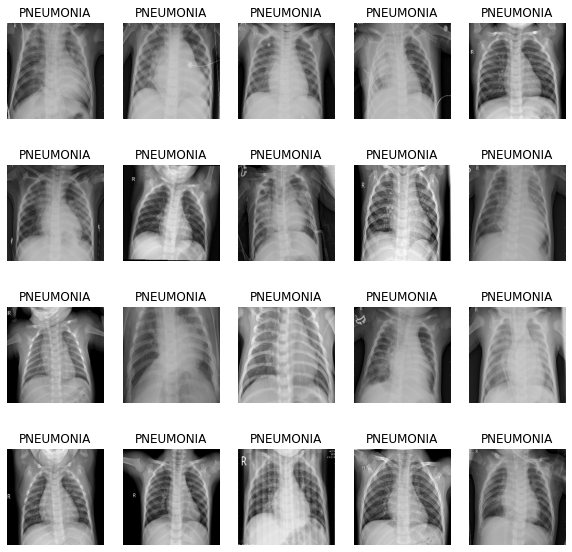

In [18]:
plt.figure(figsize=(10, 10))
for img_batch, label_batch in train_ds.take(1):
  for i in range(20):
    ax= plt.subplot(4, 5, i+1)
    plt.imshow(img_batch[i].numpy().astype("uint8"))
    plt.axis("off")
    plt.title(class_names[label_batch[0]])

In [19]:
print(len(train_ds))
print(len(test_ds))
print(len(val_ds))

163
20
1


In [20]:
# Caching and prefetching the ds for better performance
train_ds= train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds= val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
# Image Preprocessing
resize_and_rescale= tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [22]:
# Data Augmentation
data_augmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [23]:
# Model Creation
input_shape= (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes= 3

model= models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape= input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [25]:
# Model Compilation
model.compile(
    optimizer= 'adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(from_logits= False),
    metrics= ['accuracy']
)

In [26]:
# Training the ds
history= model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data= val_ds
)

Epoch 1/50
163/163 [==============================] - 50s 94ms/step - loss: 0.5525 - accuracy: 0.7465 - val_loss: 0.6662 - val_accuracy: 0.5625
Epoch 2/50
163/163 [==============================] - 15s 89ms/step - loss: 0.3360 - accuracy: 0.8600 - val_loss: 0.7713 - val_accuracy: 0.6875
Epoch 3/50
163/163 [==============================] - 14s 89ms/step - loss: 0.2490 - accuracy: 0.8976 - val_loss: 0.8030 - val_accuracy: 0.6875
Epoch 4/50
163/163 [==============================] - 15s 89ms/step - loss: 0.2352 - accuracy: 0.9105 - val_loss: 0.7795 - val_accuracy: 0.6875
Epoch 5/50
163/163 [==============================] - 14s 89ms/step - loss: 0.1999 - accuracy: 0.9235 - val_loss: 0.6758 - val_accuracy: 0.6250
Epoch 6/50
163/163 [==============================] - 14s 89ms/step - loss: 0.1837 - accuracy: 0.9327 - val_loss: 0.8285 - val_accuracy: 0.5625
Epoch 7/50
163/163 [==============================] - 14s 89ms/step - loss: 0.1854 - accuracy: 0.9314 - val_loss: 0.7355 - val_accuracy:

In [27]:
scores= model.evaluate(test_ds)

20/20 [==============================] - 4s 32ms/step - loss: 0.5443 - accuracy: 0.8077


In [28]:
history

In [29]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 163}

In [30]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [31]:
acc= history.history['accuracy']
val_acc= history.history['val_accuracy']

loss= history.history['loss']
val_loss= history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

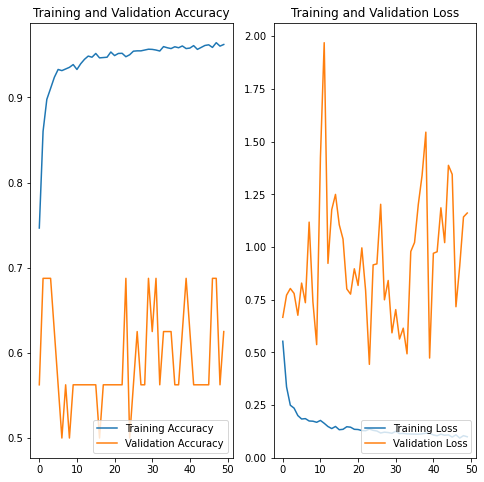

In [32]:
plt.figure(figsize=(8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label= 'Validation Accuracy')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label= 'Validation Loss')
plt.legend(loc= 'lower right')
plt.title('Training and Validation Loss')

First Image to Predict
Actual Label:  PNEUMONIA
1/1 [==============================] - 0s 126ms/step
Predicted Label:  PNEUMONIA


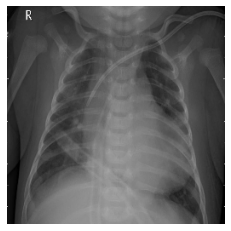

In [33]:
for images_batch, labels_batch in test_ds.take(1):
  first_image= images_batch[0].numpy().astype('uint8')
  first_label= labels_batch[0].numpy()

  print("First Image to Predict")
  plt.imshow(first_image)
  plt.axis('off')
  print("Actual Label: ", class_names[first_label])

  batch_pred= model.predict(images_batch)
  print("Predicted Label: ", class_names[np.argmax(batch_pred[0])])

In [34]:
def predict(model, img):
  img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
  img_array= tf.expand_dims(img_array, 0) # Create a batch

  predictions= model.predict(img_array)

  predicted_class= class_names[np.argmax(predictions[0])]
  confidence= round(100* (np.max(predictions[0])), 2)
  return predicted_class, confidence

1/1 [==============================] - 0s 15ms/step


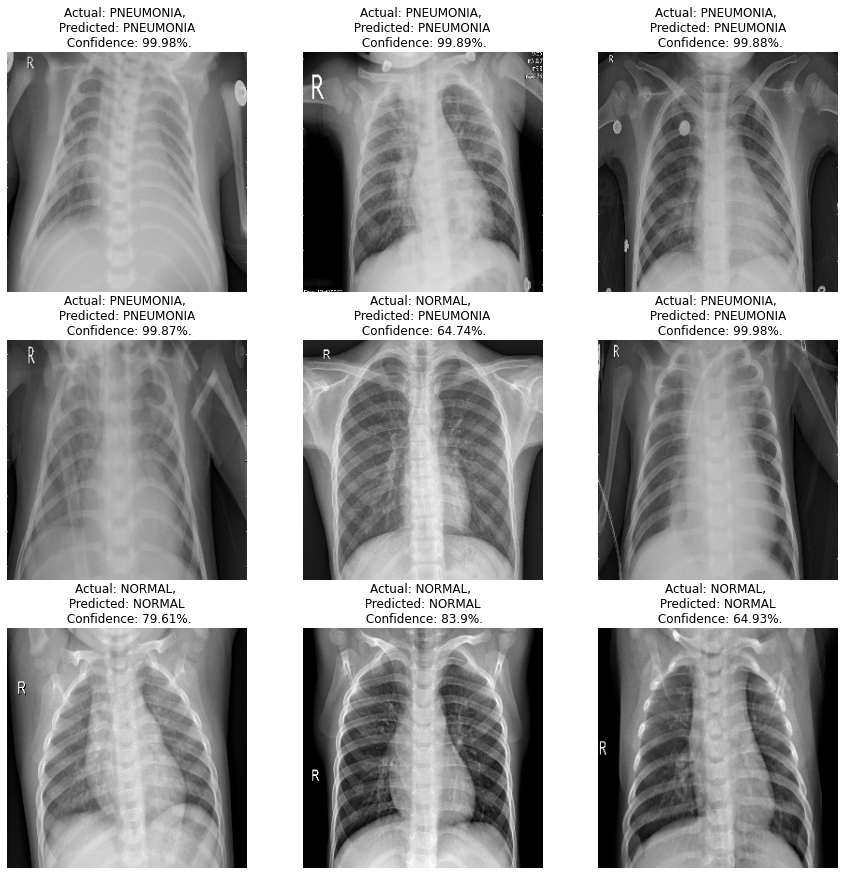

In [35]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax= plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence= predict(model,images[i].numpy())
    actual_class= class_names[labels[i]]

    plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}%.")
    plt.axis('off')


In [37]:
import os
model_version= max([int(i) for i in os.listdir("./saved_models")+ [0]])+1
model.save(f"./saved_models/{model_version}")